In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

/mnt/ml/anaconda35/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
version = 5
basic_name = f'Unet_resnet_v{version}'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)


Unet_resnet_v5.model
Unet_resnet_v5.csv


In [3]:
img_size_ori = 101
img_size_target = 128

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)



In [4]:
# Loading of training/testing ids and depths
basic_path=""
train_df = pd.read_csv(basic_path+"train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(basic_path+"depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]



len(train_df)


4000

In [8]:
train_df["images"] = [np.array(load_img(basic_path+"train/images/{}.png".format(idx), color_mode = "grayscale"))# / 255 
                          for idx in tqdm_notebook(train_df.index)]


A Jupyter Widget

In [9]:
train_df["masks"] = [np.array(load_img(basic_path+"train/masks/{}.png".format(idx), color_mode = "grayscale"))# / 255 
                         for idx in tqdm_notebook(train_df.index)]


A Jupyter Widget

In [10]:
train_df.head(10)

,z,images,masks
id,,,
575d24d81d,843,"[[134, 131, 134, 137, 136, 136, 136, 134, 123,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
a266a2a9df,794,"[[87, 96, 85, 57, 51, 92, 110, 122, 141, 141, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
75efad62c1,468,"[[145, 119, 83, 67, 70, 67, 56, 77, 113, 101, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
34e51dba6a,727,"[[138, 121, 101, 78, 52, 32, 21, 26, 47, 79, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4875705fb0,797,"[[17, 20, 23, 27, 30, 32, 34, 36, 36, 36, 38, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
782ae9b7e7,677,"[[155, 158, 158, 157, 156, 156, 157, 157, 159,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
9842f69f8d,907,"[[112, 105, 102, 116, 141, 138, 130, 139, 106,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
aa94cfb806,754,"[[129, 125, 121, 119, 119, 120, 123, 127, 130,...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
50d3073821,810,"[[119, 136, 107, 83, 113, 126, 142, 128, 109, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 21):
        if val * 20 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


/mnt/ml/anaconda35/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

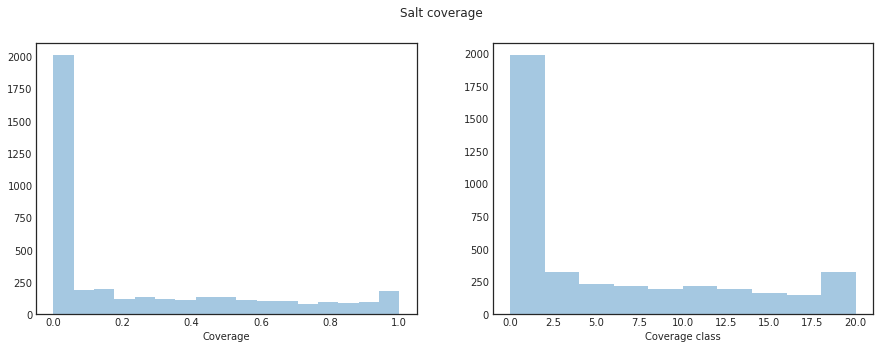

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")


/mnt/ml/anaconda35/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

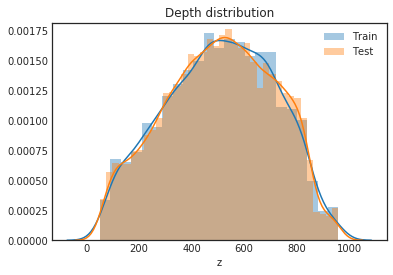

In [9]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")


In [10]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.12, stratify=train_df.coverage_class, random_state= 1224)



In [11]:
print(ids_valid.shape)
print(ids_train.shape)

(480,)
(3520,)


# Data Augment --- 使用albumentations

In [12]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision


In [13]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)



In [14]:
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(7040, 128, 128, 1)
(480, 128, 128, 1)
(7040, 128, 128, 1)
(480, 128, 128, 1)


In [15]:
mean= [0.485,0.456,0.406]
std=  [0.229,0.224,0.225]

x_train=np.concatenate((x_train-mean[2]/std[2],
                  x_train-mean[1]/std[1],
                  x_train-mean[0]/std[0]),axis=-1)

x_valid=np.concatenate((x_valid-mean[2]/std[2],
                  x_valid-mean[1]/std[1],
                  x_valid-mean[0]/std[0]),axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(7040, 128, 128, 3)
(7040, 128, 128, 1)
(480, 128, 128, 3)
(480, 128, 128, 1)


### 将增强后的数据集转换成pytorch格式 【Bs,C,H,W】

In [16]:
x_train=np.transpose(x_train,[0,3,1,2]).astype(np.float32)
y_train=np.transpose(y_train,[0,3,1,2]).astype(np.float32)

x_valid=np.transpose(x_valid,[0,3,1,2]).astype(np.float32)
y_valid=np.transpose(y_valid,[0,3,1,2]).astype(np.float32)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(7040, 3, 128, 128)
(480, 3, 128, 128)
(7040, 1, 128, 128)
(480, 1, 128, 128)


In [17]:
# 自定义一个Pytorch的数据加载器,必须继承自torch.utils.data.Dataset
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader

class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [18]:
salt_ID_dataset_train = saltIDDataset(x_train, 
                                      train=True, 
                                      preprocessed_masks=y_train)

salt_ID_dataset_val = saltIDDataset(x_valid, 
                                      train=True, 
                                      preprocessed_masks=y_valid)

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

print("Trainng samples:",train_loader.dataset.__len__())
print("Validation samples:",val_loader.dataset.__len__())

Trainng samples: 7040
Validation samples: 480


# Model define

In [19]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch
from torchvision import models
import torchvision

In [20]:
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision

"""
This script has been taken (and modified) from :
https://github.com/ternaus/TernausNet
@ARTICLE{arXiv:1801.05746,
         author = {V. Iglovikov and A. Shvets},
          title = {TernausNet: U-Net with VGG11 Encoder Pre-Trained on ImageNet for Image Segmentation},
        journal = {ArXiv e-prints},
         eprint = {1801.05746}, 
           year = 2018
        }
"""

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.BN=nn.BatchNorm2d(out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x=self.BN(x)
        x = self.activation(x)
        return x
    

class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,padding=1),
                ConvRelu(out_channels, out_channels)
            )
        else:
            self.block = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class UNetResNet(nn.Module):
    """PyTorch U-Net model using ResNet(34, 101 or 152) encoder.
    UNet: https://arxiv.org/abs/1505.04597
    ResNet: https://arxiv.org/abs/1512.03385
    Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/
    Args:
            encoder_depth (int): Depth of a ResNet encoder (34, 101 or 152).
            num_classes (int): Number of output classes.
            num_filters (int, optional): Number of filters in the last layer of decoder. Defaults to 32.
            dropout_2d (float, optional): Probability factor of dropout layer before output layer. Defaults to 0.2.
            pretrained (bool, optional):
                False - no pre-trained weights are being used.
                True  - ResNet encoder is pre-trained on ImageNet.
                Defaults to False.
            is_deconv (bool, optional):
                False: bilinear interpolation is used in decoder.
                True: deconvolution is used in decoder.
                Defaults to False.
    """

    def __init__(self, encoder_depth, num_classes, num_filters=32, dropout_2d_ration=0.5,
                 pretrained=False, is_deconv=True):
        super().__init__()
        self.num_classes = num_classes
        self.dropout_2d_ratio = dropout_2d_ration

        if encoder_depth == 34:
            self.encoder = torchvision.models.resnet34(pretrained=pretrained)
            bottom_channel_nr = 512
        elif encoder_depth == 101:
            self.encoder = torchvision.models.resnet101(pretrained=pretrained)
            bottom_channel_nr = 2048
        elif encoder_depth == 152:
            self.encoder = torchvision.models.resnet152(pretrained=pretrained)
            bottom_channel_nr = 2048
        else:
            raise NotImplementedError('only 34, 101, 152 version of Resnet are implemented')
        
        #print(self.encoder)
        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,self.encoder.bn1,self.encoder.relu)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.middle = self.encoder.layer4

        
        self.dec5 = DecoderBlockV2(512, 512, 256, is_deconv)
        
        self.dec4 = DecoderBlockV2(512, 256, 128, is_deconv)
        
        self.dec3 = DecoderBlockV2(256, 128,  64, is_deconv)
        
        self.dec2 = DecoderBlockV2(192,  96,  48, is_deconv)
        
        
        self.dec0 = ConvRelu(48, 32)
        
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        
        conv1 = self.conv1(x)
        conv1=F.dropout2d(conv1, p=self.dropout_2d_ratio/2,training=self.training)
        
        conv2 = self.conv2(conv1)
        conv2=F.dropout2d(conv2, p=self.dropout_2d_ratio,training=self.training)
        
        conv3 = self.conv3(conv2)
        conv3=F.dropout2d(conv3, p=self.dropout_2d_ratio,training=self.training)
        
        conv4 = self.conv4(conv3)
        conv4=F.dropout2d(conv4, p=self.dropout_2d_ratio,training=self.training)
        
        middle = self.middle(conv4)
        middle=F.dropout2d(middle, p=self.dropout_2d_ratio//2,training=self.training)
        
        Summary=False
        if Summary:
            print("x:",x.shape)
            print("conv1:",conv1.shape)
            print("conv2:",conv2.shape)
            print("conv3:",conv3.shape)
            print("conv4:",conv4.shape)
            print("middle:",middle.shape)
        
        
        dec5 = self.dec5(middle)
    
        tmp=torch.cat([dec5, conv4],1)
        tmp=F.dropout2d(tmp, p=self.dropout_2d_ratio,training=self.training)
        dec4 = self.dec4(tmp)
        
        tmp=torch.cat([dec4, conv3], 1)
        tmp=F.dropout2d(tmp, p=self.dropout_2d_ratio,training=self.training)
        dec3 = self.dec3(tmp)
        
        tmp=torch.cat([dec3, conv2, conv1], 1)
        tmp=F.dropout2d(tmp, p=self.dropout_2d_ratio,training=self.training)
        dec2 = self.dec2(tmp)
       
        tmp=F.dropout2d(dec2, p=self.dropout_2d_ratio,training=self.training)
        dec0 = self.dec0(tmp)
        
        logits=self.final(F.dropout2d(dec0, p=self.dropout_2d_ratio/2,training=self.training))
        
        
        if Summary:
            print("dec5:",dec5.shape)
            print("dec4:",dec4.shape)
            print("dec3:",dec3.shape)
            print("dec2:",dec2.shape)
            print("dec0:",dec0.shape)
            print("logits:",logits.shape)
        
        return logits

In [21]:
# import time 
# since=time.time()

# x=torch.randn(4,3,128,128).cuda()

# model=UNetResNet(encoder_depth=34,num_classes=1,num_filters=32, dropout_2d_ration=0.5,pretrained=False)

# model.cuda()


# out=model(x)

# 指标、loss

In [22]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0  # 关键在于这儿
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred): 
    # 假设label为torch.Tensor [bs,C,H,W] 通过label.detach().cpu().numpy()与计算图分离 pred也同样处理
    return get_iou_vector(label, pred>0.5)

def my_iou_metric_2(label, pred):
    return get_iou_vector(label, pred >0)


In [23]:
# _label=(torch.randn(32,101,101,1)>0.5).numpy()
# _logits=(torch.randn(32,101,101,1)>0.5).numpy()
# my_iou_metric(_label,_logits)


# Train Stage

In [24]:
class ArgParser(object):
    def __init__(self):
        
        self.MaxEpoch=100
        self.LR_Policy="MultiStage"
        
        self.n_gpus=1
        
        self.load_pretrained_model=False
        self.pretarined_model_path="Results"
        
        self.device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.start_save_epoch=80
        self.save_step=2

In [25]:
import time
import shutil
        
def custom_weights_init(m):
    pass 

def save_checkpoint(state, is_best, path,args):
    torch.save(state, os.path.join(args.pretarined_model_path ,'MM_best.pt'))

    
def train(model,train_loader,optimizer,criterion,args,epoch,class_weights):
    since=time.time()
    model.train()
    train_losses = []
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        
        images, masks = images.to(args.device), masks.to(args.device)
        images, masks = Variable(images), Variable(masks)
        
        logits = model(images)
        
        loss = criterion(logits, masks)
        
        train_losses.append(loss.data)
        
        #dice_loss = bioloss.dice_error(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    now=time.time()
    mean_loss=np.mean(train_losses)
    print("Mean Train Loss:{},escaped time:{}".format(mean_loss,now-since))
    return mean_loss

def test(model,test_loader,criterion,args,epoch,class_weights):
    since=time.time()
    model.eval()
    test_losses = []
    ious=[]
    
    for batch_idx, (images, masks) in enumerate(test_loader):
        
        images, masks = images.to(args.device), masks.to(args.device)
        images, masks = Variable(images), Variable(masks)
        
        logits = model(images)
        
        loss= criterion(logits, masks)
        
        test_losses.append(loss.data)
        
        pred=torch.sigmoid(logits).detach().cpu().numpy()
        iou_btach=my_iou_metric(masks.detach().cpu().numpy(), pred)
        ious.append(iou_btach)
        
    now=time.time()
    mean_loss=np.mean(test_losses)
    mean_iou=np.mean(ious)
    print("Mean Val Loss:{},Mean IOU:{}, escaped time:{}".format(mean_loss,mean_iou,now-since))
            
    return mean_loss,mean_iou
   
train_losses_history=[]
val_losses_history=[]

def main():
    
    args=ArgParser()
    
    torch.cuda.manual_seed_all(4200)# 设置全局固定随机种子方便复现
    np.random.seed(133700)
    

    model=UNetResNet(encoder_depth=34,num_classes=1,num_filters=32, dropout_2d_ration=0.5,pretrained=True)
    
#     gpu_ids=range(args.n_gpus)
#     model=nn.parallel.DataParallel(model,device_ids=gpu_ids)
    
    if args.load_pretrained_model==True:
        state=torch.load(args.pretarined_model_path)
        model.load_state_dict(state)
    else:
        model.apply(custom_weights_init)    
    
    # deploy model to GPU or CPU
    model.to(args.device)
    
    # -------------------------------------------------------------------------------- #
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,80], gamma=0.2)
    
    #criterion = nn.CrossEntropyLoss()
    #criterion = nn.BCEWithLogitsLoss()
    criterion=nn.MSELoss()
    # -------------------------------------------------------------------------------- #
    
    
    class_weights=[0.5,0.5] 
    
    best_metric=-1  # 注意指标的大小与性能的关系
    metirc_history=[]
    for epoch in range(1,args.MaxEpoch):
        
        
        mean_train_loss_=train(model,train_loader,optimizer,criterion,args,epoch,class_weights)
        train_losses_history.append(mean_train_loss_)
        
        mean_val_loss_,mean_iou_=test(model,val_loader,criterion,args,epoch,class_weights)
        val_losses_history.append(mean_val_loss_)
        
        if  epoch>=args.start_save_epoch :
            if mean_iou_>best_metric:
                best_metric=mean_iou_
                is_best=True
                save_checkpoint(model.state_dict(), is_best, args.pretarined_model_path,args)
            else:
                is_best=False
                if epoch % args.save_step ==0:
                    torch.save(model.state_dict(),"Results/MM_{}.pt".format(epoch))
        scheduler.step()
        
    torch.save(model.state_dict(),"Results/MM.pt")
    return model

   
    

In [29]:
model=main() # 模型运行时间和申请到的GPU新旧有关 第一次运行一个epoch只需要21s 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:06<00:00, 13668385.58it/s]


Mean Train Loss:0.5540709495544434,escaped time:54.08536505699158
Mean Val Loss:0.7726391553878784,Mean IOU:0.38958333333333334, escaped time:1.2559618949890137
Mean Train Loss:0.43623435497283936,escaped time:54.02131962776184
Mean Val Loss:0.6051608324050903,Mean IOU:0.23854166666666668, escaped time:1.251237154006958
Mean Train Loss:0.38836508989334106,escaped time:54.020124197006226
Mean Val Loss:0.5621757507324219,Mean IOU:0.38958333333333334, escaped time:1.2512695789337158
Mean Train Loss:0.3682606816291809,escaped time:54.02497887611389
Mean Val Loss:0.31632718443870544,Mean IOU:0.5804166666666667, escaped time:1.2517454624176025
Mean Train Loss:0.3340160846710205,escaped time:54.03168344497681
Mean Val Loss:0.2828940153121948,Mean IOU:0.6058333333333333, escaped time:1.2516093254089355
Mean Train Loss:0.3185363709926605,escaped time:54.0247642993927
Mean Val Loss:0.4714888334274292,Mean IOU:0.42937499999999995, escaped time:1.251859188079834
Mean Train Loss:0.30028781294822693

Mean Val Loss:0.16647934913635254,Mean IOU:0.7345833333333334, escaped time:1.2502100467681885
Mean Train Loss:0.13984285295009613,escaped time:53.9946506023407
Mean Val Loss:0.1375289112329483,Mean IOU:0.7454166666666667, escaped time:1.249680995941162
Mean Train Loss:0.14108605682849884,escaped time:53.99669122695923
Mean Val Loss:0.14173589646816254,Mean IOU:0.7395833333333334, escaped time:1.2501304149627686
Mean Train Loss:0.13556349277496338,escaped time:53.9932165145874
Mean Val Loss:0.1612665057182312,Mean IOU:0.7075, escaped time:1.2493062019348145
Mean Train Loss:0.14074432849884033,escaped time:53.993431091308594
Mean Val Loss:0.18343286216259003,Mean IOU:0.7254166666666666, escaped time:1.248948574066162
Mean Train Loss:0.1342318058013916,escaped time:53.99168133735657
Mean Val Loss:0.14576439559459686,Mean IOU:0.7333333333333332, escaped time:1.2491700649261475
Mean Train Loss:0.12992465496063232,escaped time:53.995802879333496
Mean Val Loss:0.14127740263938904,Mean IOU:0.